In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf

import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14095575500416452995
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40075591680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2371102615910017326
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-06-14 15:57:32.773945: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 15:57:33.727509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-06-14 15:57:33.740199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from PIL import Image
from scipy import ndimage

def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def get_full_scan(folder_path):

    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    
    a = itkimage.GetMetaData('0028|0030')
    c = itkimage.GetMetaData('0018|0050')
    #print('z spacing ',c)
    #print('xy spacing: ',a)
    mn = 1000
    mx = 0
    for file in (files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
    for file in (files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n-mn,:,:] = img[0,:,:]
    return full_scan

def dcm_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    return numpyImage, ins

import copy
def get_normalized(scann,mn,mx):
    scan = copy.copy(scann)
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def res_scan(nscan,image_size):

    depth_factor = image_size[0]/nscan.shape[0]
    width_factor = image_size[2]/nscan.shape[2]
    height_factor = image_size[1]/nscan.shape[1]
    nscann = copy.copy(nscan)
    nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
    return nscann

def res_mask(nmask,image_size):
    depth_factor = image_size[0]/nmask.shape[0]
    width_factor = image_size[2]/nmask.shape[2]
    height_factor = image_size[1]/nmask.shape[1]

    nmaskk = copy.copy(nmask)
    nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmaskk

In [3]:
trainpath = sorted(glob.glob(r"/home/rabeea/DRIVE/training/*/**/***.tif",recursive=True))
testpath = sorted(glob.glob(r"/home/rabeea/DRIVE/test/*/**/***.tif",recursive=True))
random.Random(42).shuffle(trainpath)
valpath = trainpath[-5:]
trainpath = trainpath[:-5]
print(len(trainpath), len(valpath), len(testpath))
print(valpath[:3])

15 5 20
['/home/rabeea/DRIVE/training/training/images/37_training.tif', '/home/rabeea/DRIVE/training/training/images/28_training.tif', '/home/rabeea/DRIVE/training/training/images/29_training.tif']


In [4]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    img = Image.open(img_path).convert('L')
    img = np.array(img)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    if 'test' in img_path:
        img_path = img_path[:29]+ 'mask/' + img_path.split('/')[-1][:-4] + '_mask.gif'
    else:
        img_path = img_path[:37]+ 'mask/' + img_path.split('/')[-1][:-4] + '_mask.gif'
    mask = Image.open(img_path)
    mask = np.array(mask)
    mask = cv2.resize(mask.astype(np.uint8),image_size, interpolation = cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],1))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],1),dtype = 'uint8')

        for i in range(len(images_path)):
            #print(images_path[i])
            # Read image and mask
            images_batch[i]= parse_image(images_path[i], self.image_size)
            masks_batch[i] = parse_mask(images_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [5]:
image_size = (256,256)
batch_size = 1

epochs = 350

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,batch_size=batch_size)
valid_gen = DataGen(image_size,valpath, batch_size=batch_size)
test_gen = DataGen(image_size,testpath, batch_size=1)

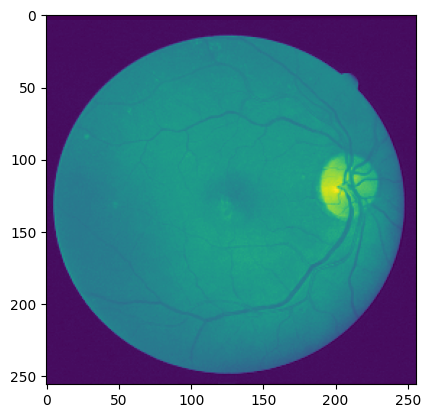

In [6]:
t = train_gen.__getitem__(3)[0]
p = train_gen.__getitem__(3)[1]
plt.imshow(t[0,:,:,0])

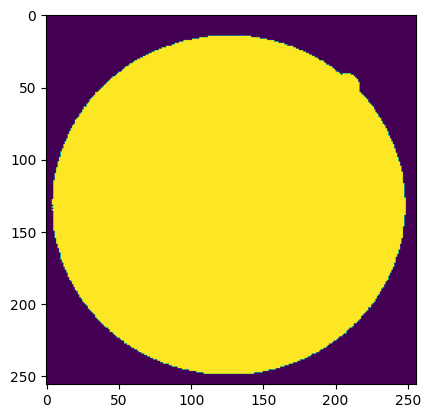

In [7]:
plt.imshow(p[0,:,:,0])

In [8]:
np.unique(p)

array([0, 1], dtype=uint8)

In [9]:

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from einops.layers.tensorflow import Rearrange
import keras_nlp
#import tensorflow_datasets as tfds

def unet(pretrained_weights = None,input_size = (256,256,1), f = 64, embedding_dim = 4, dim = 8, heads = 2):
    inputs = Input(input_size)
    scale = dim ** -0.5
    
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(f*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    

    

    up = Conv2D(f*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge = concatenate([conv3,up], axis = 3)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv2,up], axis = 3)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)

    up = Conv2D(f, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = Conv2D(f, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    conv = Conv2D(1, 1, activation = 'sigmoid')(conv)

    model = Model(inputs = inputs, outputs = conv)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss=dice_loss, metrics = [dice_coef])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [10]:
a= unet()

2023-06-14 16:00:35.155782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = r"/home/rabeea/logs/unet_drive/4layers_f64_350_256.h5"
tensorboard = TensorBoard(log_dir=r"/home/rabeea/logs/unet_drive/4layers_f64_350_256", histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]

In [12]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350


2023-06-14 16:02:06.593512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801


15/15 [==============================] - 7s 156ms/step - loss: 0.2663 - dice_coef: 0.7337 - val_loss: 0.2658 - val_dice_coef: 0.7342
Epoch 2/350
15/15 [==============================] - 2s 132ms/step - loss: 0.2533 - dice_coef: 0.7467 - val_loss: 0.2388 - val_dice_coef: 0.7612
Epoch 3/350
15/15 [==============================] - 2s 126ms/step - loss: 0.2454 - dice_coef: 0.7546 - val_loss: 0.2451 - val_dice_coef: 0.7549
Epoch 4/350
15/15 [==============================] - 2s 140ms/step - loss: 0.2365 - dice_coef: 0.7635 - val_loss: 0.2297 - val_dice_coef: 0.7703
Epoch 5/350
15/15 [==============================] - 2s 138ms/step - loss: 0.2231 - dice_coef: 0.7769 - val_loss: 0.2095 - val_dice_coef: 0.7905
Epoch 6/350
15/15 [==============================] - 2s 144ms/step - loss: 0.2048 - dice_coef: 0.7952 - val_loss: 0.2026 - val_dice_coef: 0.7974
Epoch 7/350
15/15 [==============================] - 2s 132ms/step - loss: 0.2006 - dice_coef: 0.7994 - val_loss: 0.2008 - val_dice_coef: 0.79

15/15 [==============================] - 2s 130ms/step - loss: 0.1807 - dice_coef: 0.8193 - val_loss: 0.1805 - val_dice_coef: 0.8195
Epoch 58/350
15/15 [==============================] - 2s 130ms/step - loss: 0.1803 - dice_coef: 0.8197 - val_loss: 0.1801 - val_dice_coef: 0.8199
Epoch 59/350
15/15 [==============================] - 2s 130ms/step - loss: 0.1799 - dice_coef: 0.8201 - val_loss: 0.1799 - val_dice_coef: 0.8201
Epoch 60/350
15/15 [==============================] - 2s 124ms/step - loss: 0.1797 - dice_coef: 0.8203 - val_loss: 0.1794 - val_dice_coef: 0.8206
Epoch 61/350
15/15 [==============================] - 2s 128ms/step - loss: 0.1793 - dice_coef: 0.8207 - val_loss: 0.1793 - val_dice_coef: 0.8207
Epoch 62/350
15/15 [==============================] - 2s 128ms/step - loss: 0.1790 - dice_coef: 0.8210 - val_loss: 0.1787 - val_dice_coef: 0.8213
Epoch 63/350
15/15 [==============================] - 2s 130ms/step - loss: 0.1786 - dice_coef: 0.8214 - val_loss: 0.1784 - val_dice_coef

15/15 [==============================] - 2s 132ms/step - loss: 0.1629 - dice_coef: 0.8371 - val_loss: 0.1627 - val_dice_coef: 0.8373
Epoch 114/350
15/15 [==============================] - 2s 137ms/step - loss: 0.1626 - dice_coef: 0.8374 - val_loss: 0.1624 - val_dice_coef: 0.8376
Epoch 115/350
15/15 [==============================] - 2s 131ms/step - loss: 0.1623 - dice_coef: 0.8377 - val_loss: 0.1622 - val_dice_coef: 0.8378
Epoch 116/350
15/15 [==============================] - 2s 137ms/step - loss: 0.1620 - dice_coef: 0.8380 - val_loss: 0.1618 - val_dice_coef: 0.8382
Epoch 117/350
15/15 [==============================] - 2s 141ms/step - loss: 0.1617 - dice_coef: 0.8383 - val_loss: 0.1615 - val_dice_coef: 0.8385
Epoch 118/350
15/15 [==============================] - 2s 135ms/step - loss: 0.1614 - dice_coef: 0.8386 - val_loss: 0.1612 - val_dice_coef: 0.8388
Epoch 119/350
15/15 [==============================] - 2s 131ms/step - loss: 0.1612 - dice_coef: 0.8388 - val_loss: 0.1611 - val_dic

Epoch 169/350
15/15 [==============================] - 2s 128ms/step - loss: 0.1468 - dice_coef: 0.8532 - val_loss: 0.1467 - val_dice_coef: 0.8533
Epoch 170/350
15/15 [==============================] - 2s 135ms/step - loss: 0.1465 - dice_coef: 0.8535 - val_loss: 0.1465 - val_dice_coef: 0.8535
Epoch 171/350
15/15 [==============================] - 2s 139ms/step - loss: 0.1463 - dice_coef: 0.8537 - val_loss: 0.1463 - val_dice_coef: 0.8537
Epoch 172/350
15/15 [==============================] - 2s 143ms/step - loss: 0.1460 - dice_coef: 0.8540 - val_loss: 0.1460 - val_dice_coef: 0.8540
Epoch 173/350
15/15 [==============================] - 2s 140ms/step - loss: 0.1457 - dice_coef: 0.8543 - val_loss: 0.1456 - val_dice_coef: 0.8544
Epoch 174/350
15/15 [==============================] - 2s 133ms/step - loss: 0.1454 - dice_coef: 0.8546 - val_loss: 0.1454 - val_dice_coef: 0.8546
Epoch 175/350
15/15 [==============================] - 2s 135ms/step - loss: 0.1452 - dice_coef: 0.8548 - val_loss: 0.

Epoch 225/350
15/15 [==============================] - 2s 132ms/step - loss: 0.1321 - dice_coef: 0.8679 - val_loss: 0.1321 - val_dice_coef: 0.8679
Epoch 226/350
15/15 [==============================] - 2s 135ms/step - loss: 0.1319 - dice_coef: 0.8681 - val_loss: 0.1319 - val_dice_coef: 0.8681
Epoch 227/350
15/15 [==============================] - 2s 132ms/step - loss: 0.1317 - dice_coef: 0.8683 - val_loss: 0.1316 - val_dice_coef: 0.8684
Epoch 228/350
15/15 [==============================] - 2s 133ms/step - loss: 0.1314 - dice_coef: 0.8686 - val_loss: 0.1314 - val_dice_coef: 0.8686
Epoch 229/350
15/15 [==============================] - 2s 128ms/step - loss: 0.1311 - dice_coef: 0.8689 - val_loss: 0.1311 - val_dice_coef: 0.8689
Epoch 230/350
15/15 [==============================] - 2s 139ms/step - loss: 0.1309 - dice_coef: 0.8691 - val_loss: 0.1309 - val_dice_coef: 0.8691
Epoch 231/350
15/15 [==============================] - 2s 132ms/step - loss: 0.1306 - dice_coef: 0.8694 - val_loss: 0.

Epoch 281/350
15/15 [==============================] - 2s 136ms/step - loss: 0.1187 - dice_coef: 0.8813 - val_loss: 0.1189 - val_dice_coef: 0.8811
Epoch 282/350
15/15 [==============================] - 2s 129ms/step - loss: 0.1185 - dice_coef: 0.8815 - val_loss: 0.1186 - val_dice_coef: 0.8814
Epoch 283/350
15/15 [==============================] - 2s 137ms/step - loss: 0.1182 - dice_coef: 0.8818 - val_loss: 0.1184 - val_dice_coef: 0.8816
Epoch 284/350
15/15 [==============================] - 2s 107ms/step - loss: 0.1180 - dice_coef: 0.8820 - val_loss: 0.1184 - val_dice_coef: 0.8816
Epoch 285/350
15/15 [==============================] - 2s 129ms/step - loss: 0.1178 - dice_coef: 0.8822 - val_loss: 0.1181 - val_dice_coef: 0.8819
Epoch 286/350
15/15 [==============================] - 2s 128ms/step - loss: 0.1175 - dice_coef: 0.8825 - val_loss: 0.1178 - val_dice_coef: 0.8822
Epoch 287/350
15/15 [==============================] - 2s 131ms/step - loss: 0.1173 - dice_coef: 0.8827 - val_loss: 0.

Epoch 337/350
15/15 [==============================] - 2s 135ms/step - loss: 0.1068 - dice_coef: 0.8932 - val_loss: 0.1069 - val_dice_coef: 0.8931
Epoch 338/350
15/15 [==============================] - 2s 132ms/step - loss: 0.1068 - dice_coef: 0.8932 - val_loss: 0.1065 - val_dice_coef: 0.8935
Epoch 339/350
15/15 [==============================] - 2s 134ms/step - loss: 0.1064 - dice_coef: 0.8936 - val_loss: 0.1063 - val_dice_coef: 0.8937
Epoch 340/350
15/15 [==============================] - 2s 132ms/step - loss: 0.1061 - dice_coef: 0.8939 - val_loss: 0.1060 - val_dice_coef: 0.8940
Epoch 341/350
15/15 [==============================] - 2s 124ms/step - loss: 0.1059 - dice_coef: 0.8941 - val_loss: 0.1058 - val_dice_coef: 0.8942
Epoch 342/350
15/15 [==============================] - 2s 133ms/step - loss: 0.1057 - dice_coef: 0.8943 - val_loss: 0.1056 - val_dice_coef: 0.8944
Epoch 343/350
15/15 [==============================] - 2s 111ms/step - loss: 0.1054 - dice_coef: 0.8946 - val_loss: 0.

In [13]:
a.load_weights(filepath)

In [14]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

training dice:  0.8960649967193604
validation dice:  0.895926833152771


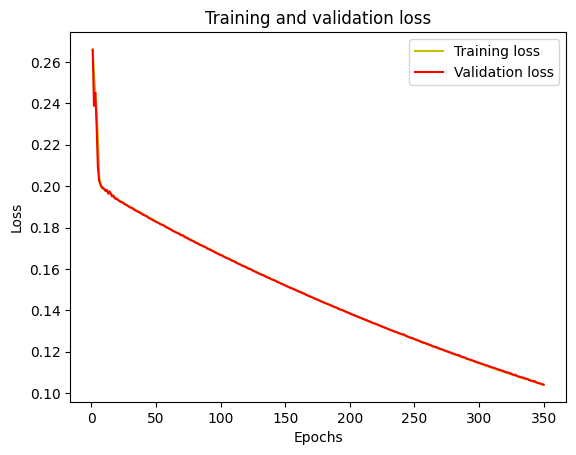

In [15]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

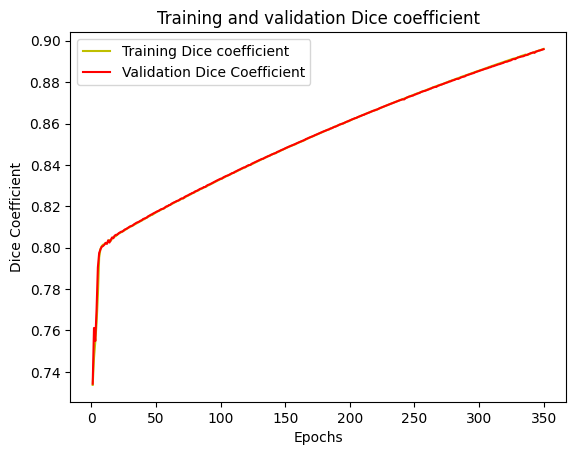

In [16]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [17]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                    | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1634204/4120540149.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_1634204/4120540149.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|███████████████

at 0.9: dice:  0.0
at 0.8: dice:  0.0
at 0.7: dice:  0.0
at 0.6: dice:  0.997920708638582
at 0.5: dice:  0.9979197708323927
at 0.4: dice:  0.9979083024241862
at 0.3: dice:  0.9978581451991111
at 0.2: dice:  0.9977903088156964
at 0.1: dice:  0.9975943837997224
at 0.05: dice:  0.9973764209853266
at 0.01: dice:  0.9967186154192996
